# Summary
This demonstrates reconstruction of a Fresnel CDI dataset and compares the result to ePIE reconstruction. 

The probe structure allows reconstruction in CDI mode, i.e. without real-space overlap constraints. 

Scanning CDI reconstruction is also possible here, but results in a lower-quality image because of scan position jitter in this dataset.

## Object ePIE reconstruction: 
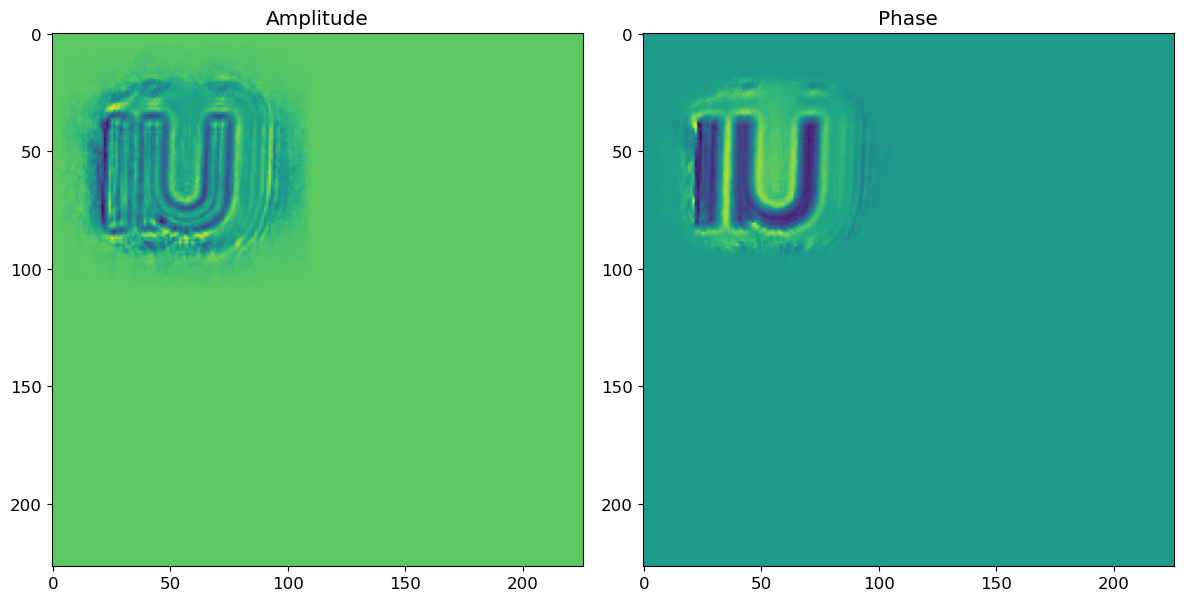

In [1]:
from scipy.ndimage import zoom
import numpy as np

def init():
    from ptycho import params as p
    
    p.cfg['nepochs'] = 50
    p.cfg['output_prefix'] = 'tmp'
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['positions.provided'] = True
    p.cfg['probe.big'] = True
    p.cfg['probe.mask'] = False

    p.cfg['data_source'] = 'generic'
    p.cfg['gridsize'] = 1
    p.cfg['probe_scale'] = 5
    p.cfg['train_data_file_path'] = 'train_data.npz'
    p.cfg['test_data_file_path'] = 'test_data.npz'


# IMPORTANT: must call init() BEFORE the dataset definition
init()

In [10]:
# !ln -s ../tests/test_generic_loader.py
import test_generic_loader;
train_raw, test_raw = test_generic_loader.test_generic_loader(False);

Train data written to train_data.npz
Train data written to test_data.npz


In [11]:
from ptycho import probe
from ptycho import params as p

from ptycho.xpp import *
probe_amp = np.absolute(probeGuess)
mask = np.absolute(p.get('probe_mask'))[:, :, 0, 0]
probe.set_probe_guess(None, probeGuess)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

In [12]:
tf.random.set_seed(45)
np.random.seed(45)
from ptycho import params as p
from ptycho import train, model
from ptycho.train import *
from ptycho.nbutils import *

# channel dimensions size should be 1 in CDI mode, 4 in ptycho mode
test_data['X'].shape, train_data['X'].shape

(TensorShape([1024, 64, 64, 1]), TensorShape([512, 64, 64, 1]))

# Dataset description

In [13]:
print(test_raw)

RawData: 
xcoords: (1024,) 
ycoords: (1024,) 
xcoords_start: (1024,) 
ycoords_start: (1024,) 
diff3d: (1024, 64, 64) 
probeGuess: (64, 64) 
scan_index: (1024,) 
objectGuess: Present


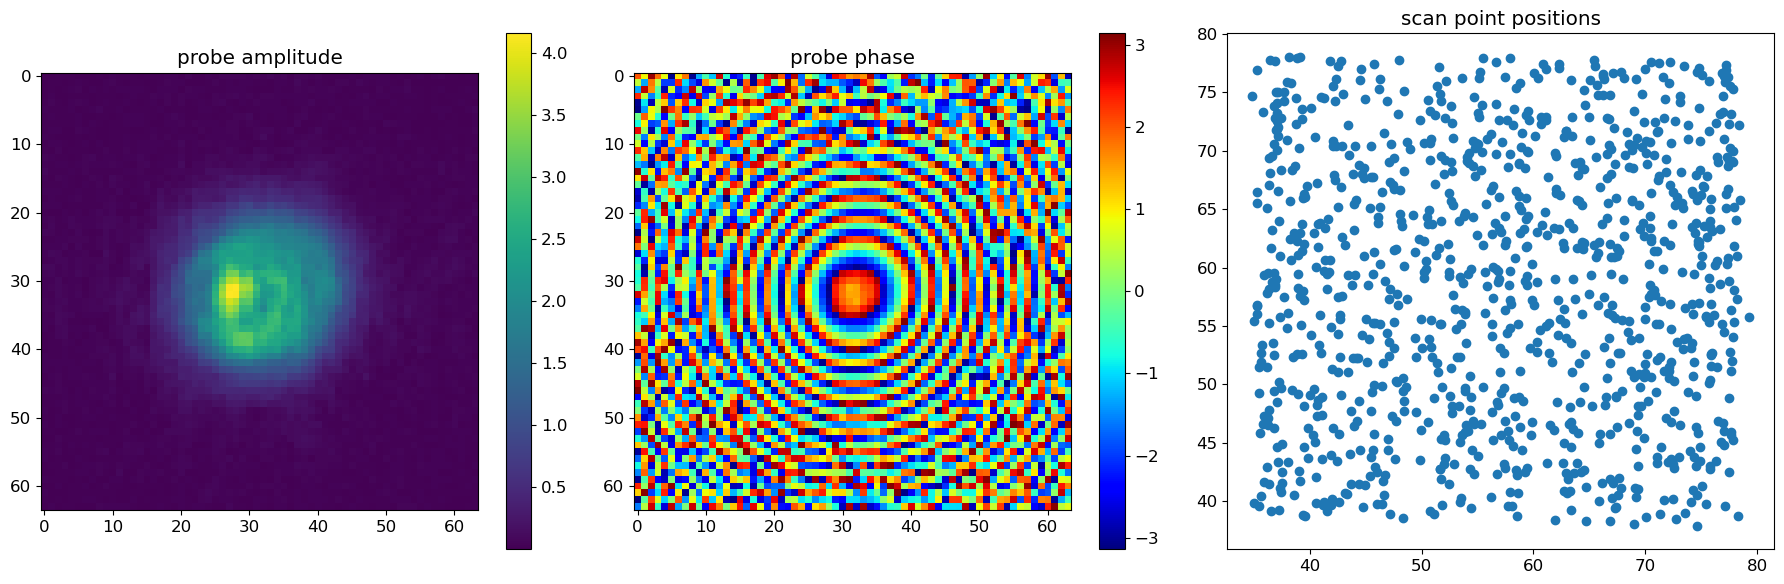

In [14]:
# Note the randomized scan point positions
probeshow(probeGuess, test_data)

## Reconstruct the full test object image and compare to the ePIE reconstruction:

32/32 [==============================] - 0s 8ms/step


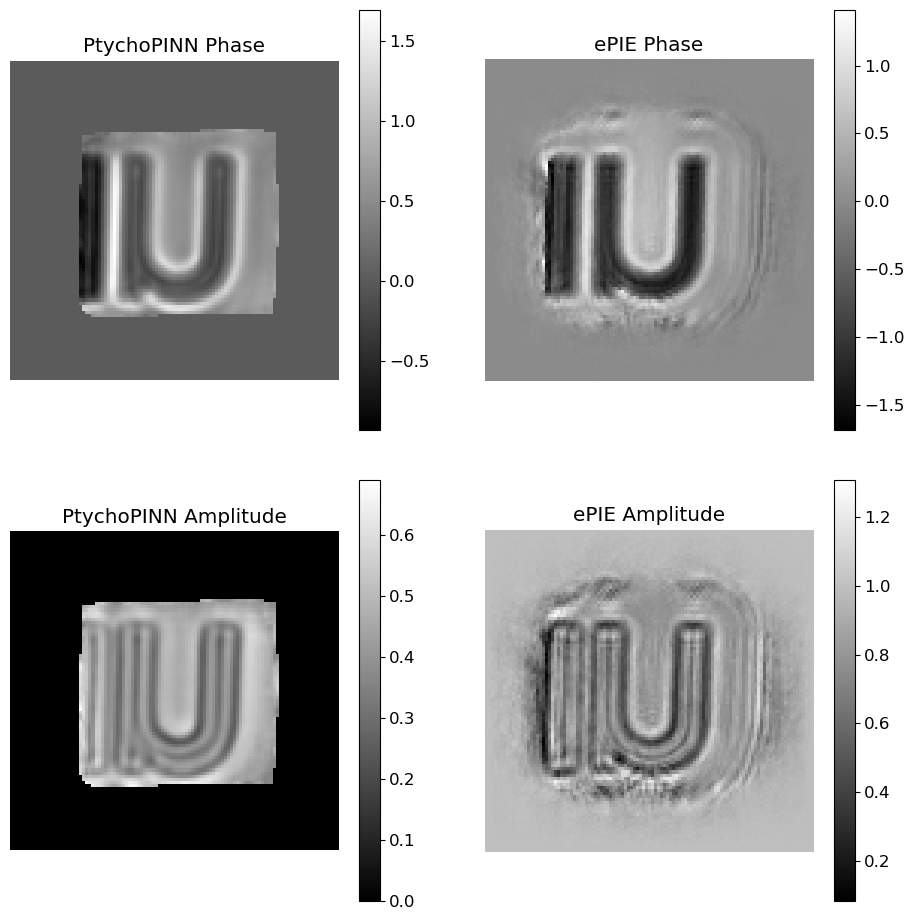

CPU times: user 365 ms, sys: 343 ms, total: 708 ms
Wall time: 672 ms


In [9]:
%%time
obj_tensor_full, global_offsets = reconstruct_image(test_data)
obj_image = loader.reassemble_position(obj_tensor_full, global_offsets[:, :, :, :], M = 20)

recon_amp_ptychopinn = np.absolute(obj_image)
recon_phase_ptychopinn = np.angle(obj_image)

ptycho_pinn_phase = crop_to_non_uniform_region_with_buffer(recon_phase_ptychopinn[..., 0], buffer=23)
ptycho_pinn_amplitude = crop_to_non_uniform_region_with_buffer(recon_amp_ptychopinn[..., 0], buffer=23)

epie_phase = crop_to_non_uniform_region_with_buffer(np.angle(obj['objectGuess']))
epie_amplitude = crop_to_non_uniform_region_with_buffer(np.absolute(obj['objectGuess']))

mk_epie_comparison2x2(ptycho_pinn_phase, epie_phase, ptycho_pinn_amplitude,epie_amplitude)

Reconstruction for a single solution region:

phase min: -3.0322459 phase max: 2.8536286


/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/ptychoPINN-0.0.0-py3.9.egg/ptycho/evaluation.py:80: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


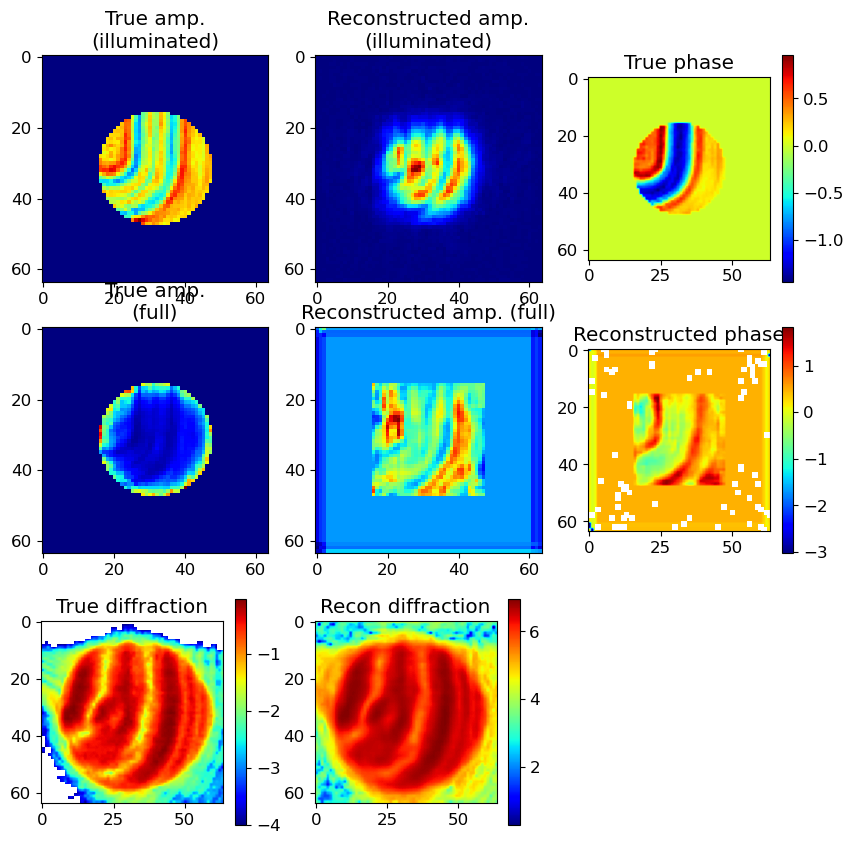

In [12]:
i = 200
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test,
                     np.absolute(p.get('probe')[:, :, 0]), 0,
                    crop = False);